## Same to Exp_MNIST.ipynb, but for CIFAR

In [1]:
import torch
import torchvision
from torchvision.datasets import CIFAR10
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_dir = "/scratch/qingqu_root/qingqu1/xlxiao/DL/data/"
c10_train = CIFAR10(root=data_dir, download=True, train=True, transform=None)
c10_test = CIFAR10(root=data_dir, download=True, train=False, transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def pad_image(image,pad_size,left=True):
    pad_one_end = np.random.randint(int(pad_size//4))
    pad_other_end = int(pad_size - pad_one_end)
    if left:
        new_image = F.pad(image, (pad_other_end, pad_one_end, pad_other_end, pad_one_end),"constant", 0)
    else: 
        new_image = F.pad(image, (pad_one_end, pad_other_end, pad_one_end, pad_other_end),"constant", 0)
    return new_image

def create_m1_samples(data, targets, class_size=5000, pad_size=32):
    all_data = []
    all_targets = []
    for cla_idx in range(10):
        cla_length = np.sum(targets==cla_idx).item()
        # Some randomness
        chosen_ones = np.random.permutation(cla_length)[:class_size]
        cur_cla_data = data[targets==cla_idx][chosen_ones]
        for i in range(class_size):
            first_left = torch.rand(1) < 0.5
            im = cur_cla_data[i]
            cur_data = pad_image(torch.from_numpy(im).float().permute(2,0,1), pad_size, first_left)
            all_data.append(cur_data)
            
            cur_target = torch.zeros(10)
            cur_target[cla_idx] = 1.0
            all_targets.append(cur_target)
    return torch.stack(all_data, dim=0), torch.stack(all_targets, dim=0)

def create_m2_samples(data, targets, class_size=5000, pad_size=28):
    all_data = []
    all_targets = []
    for idx_1 in range(10):
        for idx_2 in range(idx_1+1, 10):
            cla_length_1 = np.sum(targets==idx_1).item()
            cla_length_2 = np.sum(targets==idx_2).item()
            # Some randomness
            chosen_ones_1 = np.random.permutation(cla_length_1)[:class_size]
            chosen_ones_2 = np.random.permutation(cla_length_2)[:class_size]
            cla_data_1 = data[targets==idx_1][chosen_ones_1]
            cla_data_2 = data[targets==idx_2][chosen_ones_2]
        
            for i in range(class_size):
                first_left = torch.rand(1) < 0.5
                cur_data_1 = pad_image(torch.from_numpy(cla_data_1[i]).float().permute(2,0,1), pad_size, left=first_left)
                cur_data_2 = pad_image(torch.from_numpy(cla_data_2[i]).float().permute(2,0,1), pad_size, left=not first_left)
                all_data.append(torch.maximum(cur_data_1, cur_data_2))

                cur_target = torch.zeros(10)
                cur_target[idx_1] = 0.5
                cur_target[idx_2] = 0.5
                all_targets.append(cur_target)
    return torch.stack(all_data, dim=0), torch.stack(all_targets, dim=0)

def create_m3_samples(data, targets, class_size=5000, pad_size=28):
    all_data = []
    all_targets = []
    for idx_1 in range(10):
        for idx_2 in range(idx_1+1, 10):
            for idx_3 in range(idx_2+1, 10):
                cla_length_1 = np.sum(targets==idx_1).item()
                cla_length_2 = np.sum(targets==idx_2).item()
                cla_length_3 = np.sum(targets==idx_3).item()
                # Some randomness
                chosen_ones_1 = np.random.permutation(cla_length_1)[:class_size]
                chosen_ones_2 = np.random.permutation(cla_length_2)[:class_size]
                chosen_ones_3 = np.random.permutation(cla_length_3)[:class_size]
                cla_data_1 = data[targets==idx_1][chosen_ones_1]
                cla_data_2 = data[targets==idx_2][chosen_ones_2]
                cla_data_3 = data[targets==idx_3][chosen_ones_3]
            
                for i in range(class_size):
                    first_left = torch.rand(1) < 0.5
                    cur_data_1 = pad_image(torch.from_numpy(cla_data_1[i]).float().permute(2,0,1), pad_size, left=first_left)
                    cur_data_2 = pad_image(torch.from_numpy(cla_data_2[i]).float().permute(2,0,1), pad_size, left=not first_left)
                    cur_data_3 = pad_image(torch.from_numpy(cla_data_3[i]).float().permute(2,0,1), pad_size, left=not first_left)
                    all_data.append(torch.maximum(cur_data_1, cur_data_2, cur_data_3))

                    cur_target = torch.zeros(10)
                    cur_target[idx_1] = 1/3
                    cur_target[idx_2] = 1/3
                    cur_target[idx_3] = 1/3
                    all_targets.append(cur_target)
    return torch.stack(all_data, dim=0), torch.stack(all_targets, dim=0)

def create_dataset(num_samples, data, targets, pad_size=32):
    m1_num, m2_num = num_samples
    m1_data, m1_targets = create_m1_samples(data, targets, class_size=m1_num, pad_size=pad_size)
    m2_data, m2_targets = create_m2_samples(data, targets, class_size=m2_num, pad_size=pad_size)
    
    return torch.cat([m1_data, m2_data], dim=0), torch.cat([m1_targets, m2_targets], dim=0)

In [4]:
trainset, trainlabels = create_dataset([3100, 200], c10_train.data / np.max(c10_train.data), 
                                       np.array(c10_train.targets), pad_size=32)
testset, testlabels = create_dataset([800, 50], c10_test.data / np.max(c10_train.data), 
                                       np.array(c10_test.targets), pad_size=32)

In [5]:
import pickle
to_save = {
            "train_data": trainset,
            "train_label": trainlabels,
            "test_data": testset,
            "test_label": testlabels
            }
    
with open("/scratch/qingqu_root/qingqu1/xlxiao/DL/data/c10_combine.pkl", 'wb') as f: 
    pickle.dump(to_save, f)

tensor([0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])


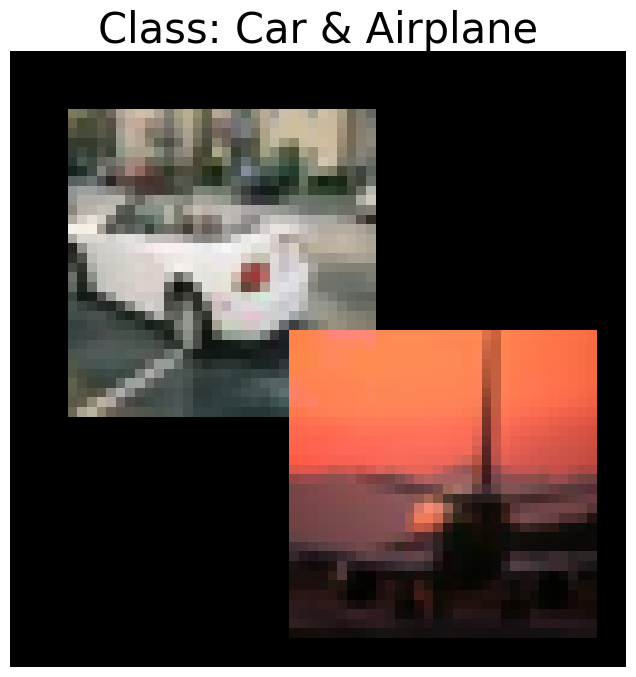

In [120]:
idx = 31003 # 31003
fig = plt.figure(figsize=(8,8))
plt.imshow(trainset[idx].permute(1,2,0))
plt.axis("off")
plt.title("Class: Car & Airplane", fontsize=30)
fig.savefig("figs/c10_car_airplane.pdf", bbox_inches='tight')

print(trainlabels[idx])


In [121]:
from define_data import MNIST_Combine

trainset_mnist = MNIST_Combine("/scratch/qingqu_root/qingqu1/xlxiao/DL/data/mnist_combine.pkl", train=True)

tensor([0.0000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])


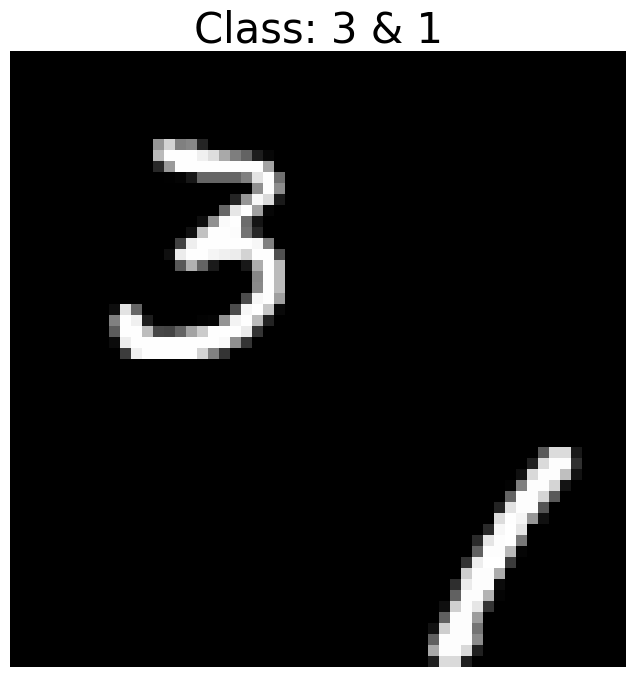

In [137]:
idx = 33004

fig = plt.figure(figsize=(8,8))
plt.imshow(trainset_mnist[idx][0][0], cmap="gray")
plt.axis("off")
plt.title("Class: 3 & 1", fontsize=30)
fig.savefig("figs/mnist_3_1.pdf", bbox_inches='tight')

print(trainset_mnist[idx][1])